# 2.5D DC Resistivity Inversion

This tutorial demonstrates DC resistivity inversion with SimPEG. We load normalized voltage data and 2D topography for a synthetic pole-dipole survey. Once loaded, we demonstrate a standard set of steps for recovering a model that characterizing subsurface electrical resistivity using weighted least-squares inversion.

The following items are emphasized in this tutorial:

- Assigning uncertainties to DC resistivity data.
- Designing a suitable mesh based on survey geometry.
- What model parameters we should invert for.
- Defining the inverse problem (data misfit, regularization, optimization).
- Stopping criteria for the inversion.
- Assessing inversion outputs.

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/dcr_inv.png" width="100%" align="center"/>

## Step 0: Importing Modules

In [ ]:
# SimPEG functionality
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
    apparent_resistivity_from_voltage,
    pseudo_locations,
)
from SimPEG.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc
from SimPEG.utils import model_builder, Counter
from SimPEG import (
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Basic Python functionality
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Pooch for downloading files from the web
import pooch

mpl.rcParams.update({"font.size": 14})  # default font size
cmap = mpl.cm.RdYlBu_r  # default colormap

Below is a class specifically used for this tutorial. It is not important to spent time reading through the code in this cell.

In [ ]:
class SaveInversionProgress(directives.InversionDirective, Counter):
    """
    A custom directive to save items of interest during the course of an inversion
    """

    def initialize(self):
        """
        This is called when we first start running an inversion
        """
        # initialize an empty dictionary for storing results
        self.inversion_results = {
            "iteration": [],
            "beta": [],
            "phi_d": [],
            "phi_m": [],
            "phi_m_small": [],
            "phi_m_smooth_x": [],
            "phi_m_smooth_z": [],
            "dpred": [],
            "model": [],
        }

    def endIter(self):
        """
        This is run at the end of every iteration. So here, we just append
        the new values to our dictionary
        """

        self.inversion_results["iteration"].append(self.opt.iter)
        self.inversion_results["beta"].append(self.invProb.beta)
        self.inversion_results["phi_d"].append(2 * self.invProb.phi_d)
        self.inversion_results["phi_m"].append(2 * self.invProb.phi_m)
        self.inversion_results["dpred"].append(self.invProb.dpred)
        self.inversion_results["model"].append(self.invProb.model)

        reg = self.reg.objfcts[0]
        phi_s = reg.objfcts[0](self.invProb.model) * reg.multipliers[0]
        phi_x = reg.objfcts[1](self.invProb.model) * reg.multipliers[1]
        phi_z = reg.objfcts[2](self.invProb.model) * reg.multipliers[2]

        self.inversion_results["phi_m_small"].append(phi_s)
        self.inversion_results["phi_m_smooth_x"].append(phi_x)
        self.inversion_results["phi_m_smooth_z"].append(phi_z)

## Step1: Load Data and Plot

### Download the Data

In [ ]:
topo_url = "https://github.com/simpeg/agrogeo24/raw/main/data/topo_2d.txt"
topo_hash = "1B2DAC5C46E48AB1C5606BB14621279C0A86DFD7790674A9FAAD83F3595E7030"

topo_filename = pooch.retrieve(topo_url, known_hash=topo_hash)

In [ ]:
data_url = "https://github.com/simpeg/agrogeo24/raw/main/data/dc_data.obs"
data_hash = "EBA4F058B5189DB974E261F4C0B4C18B7841F29E6304F3138E94FACB436A2E58"

data_filename = pooch.retrieve(data_url, known_hash=data_hash)

### Load Topography

In [ ]:
topo_2d = np.loadtxt(str(topo_filename))
print(topo_2d)

### Load the Observed Data

In [ ]:
dc_data = read_dcip2d_ubc(data_filename, "volt", "general")

### Plot the Topography and Electrode Locations

In [ ]:
unique_locations = dc_data.survey.unique_electrode_locations

fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(topo_2d[:, 0], topo_2d[:, -1], color="b", linewidth=1)
ax.plot(unique_locations[:, 0], unique_locations[:, -1], "ro", markersize=4)
ax.set_xlim([topo_2d[:, 0].min(), topo_2d[:, 0].max()])
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("y (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography and Electrode Locations", fontsize=16, pad=10)
plt.show(fig)

### Plot Observed Data in Pseudo-Section

In [ ]:
# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    dc_data,
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Normalized Voltages")
plt.show()

# Get apparent conductivities from volts and survey geometry
apparent_resistivities = apparent_resistivity_from_voltage(dc_data.survey, dc_data.dobs)

# Plot apparent resistivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    dc_data.survey,
    apparent_resistivities,
    plot_type="contourf",
    data_locations=True,
    ax=ax1,
    scale="log",
    cbar_label="$\Omega m$",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Apparent Resistivity")
plt.show()

## Step 2: Assign Uncertainties 

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/true_observed_data.png" width="100%" align="center"/>

### <span style="color:darkgreen">Exercise (beginner):</span>

Uncertainties are estimates of the standard deviations of the noise on our data. Assign uncertainties of 1e-7 V/A + 8 % to all data. We can do this by setting the *standard_deviation* property of our *data object*.

In [ ]:
inds_sort = np.argsort(np.abs(dc_data.dobs))
sorted_data = np.abs(dc_data.dobs[inds_sort])
sorted_std = dc_data.standard_deviation[inds_sort]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

x_plot = np.arange(0, len(sorted_data))
ax.semilogy(x_plot, sorted_data, "k.", markersize=1)

ax.set_title("Sorted Data and Uncertainties")
ax.fill_between(x_plot, sorted_data - sorted_std, sorted_data + sorted_std, alpha=0.5)
ax.grid(alpha=0.5)
ax.set_ylabel("Observed Data (V/A)")

## Step 3: Designing a (Tree) Mesh

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/tree_mesh.png" width="70%" align="center"/>

### <span style="color:darkgreen">Exercise (beginner):</span>

Define and provide reasonable values for the following variables:

* **dh** (minimum cell width)
* **dom_width_x** (width of the domain along x)
* **dom_width_y** (width of the domain along y)

To do this, we access information from our data object. Here we:

1. Obtain the unique electrode locations from the *dc_data* object
2. Use this to find the minimum and maximum electrode spacing
3. Use this to determine good values for *dh*, *dom_width_x* and *dom_width_y*

In [ ]:
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcy = 2 ** int(np.round(np.log(dom_width_y / dh) / np.log(2.0)))  # num. base cells y

# Define the base mesh with top at z = 0 m
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
mesh = TreeMesh([hx, hy], origin="CN")

# Shift top to maximum topography and center of survey line
y_topo_max = np.max(topo_2d[:, -1])
mesh.origin = mesh.origin + np.r_[np.median(topo_2d[:, 0]), y_topo_max]

In [ ]:
# Mesh refinement based on topography
mesh.refine_surface(
    topo_2d[np.abs(topo_2d[:, 0]) < 150.0, :],
    padding_cells_by_level=[0, 0, 4, 4],
    finalize=False,
)

# Extract unique electrode locations.
unique_locations = dc_data.survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(
    unique_locations, padding_cells_by_level=[10, 8, 8, 8, 4, 4], finalize=False
)

In [ ]:
# Finalize the mesh
mesh.finalize()

In [ ]:
fig = plt.figure(figsize=(8, 4))

ax1 = fig.add_axes([0.14, 0.17, 0.8, 0.7])
mesh.plot_grid(ax=ax1, linewidth=1)
ax1.grid(False)
ax1.set_xlim(-200, 200)
ax1.set_ylim(y_topo_max - 200, y_topo_max)
ax1.set_title("Mesh")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

plt.show()

## Step 4: Define the Active Cells

Use the [active_from_xyz](https://discretize.simpeg.xyz/en/main/api/generated/discretize.utils.active_from_xyz.html) utility function to find the indices of the active cells using the mesh and surface topography. The output quantity is a ``bool`` array.

In [ ]:
active_cells = active_from_xyz(mesh, topo_2d)

## Step 5: Project Survey to Discretized Topography

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/project_electrodes.png" width="30%" align="center"/>

Use the [drape_electrodes_on_topography](https://docs.simpeg.xyz/content/api/generated/SimPEG.electromagnetics.static.resistivity.Survey.drape_electrodes_on_topography.html#SimPEG.electromagnetics.static.resistivity.Survey.drape_electrodes_on_topography) method to project electrodes to the discrete surface topography.

In [ ]:
dc_data.survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

## Step 6: Mapping from the Model to the Mesh

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/mapping_2.png" width="80%" align="center"/>

### <span style="color:darkgreen">Exercise (beginner):</span>

1. Determine the number of active cells (i.e. the number of model parameters)
2. Generate an [SimPEG.maps.ExpMap](https://docs.simpeg.xyz/content/api/generated/SimPEG.maps.ExpMap.html#SimPEG.maps.ExpMap) mapping object to map log-resistivities to resistivities.
3. Generate a [SimPEG.maps.InjectActiveCells](https://docs.simpeg.xyz/content/api/generated/SimPEG.maps.InjectActiveCells.html#SimPEG.maps.InjectActiveCells) mapping object to project values on active cells to the entire mesh. Make sure to fix the value of inactive (air) cells to 1e8 Ohm meters.
4. Use the \* operator to combine the separate mapping objects into a single mapping. Your final mapping should be called **log_resistivity_map**.

## Step 7: Define the Forward Simulation

In [ ]:
dc_simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=dc_data.survey, rhoMap=log_resistivity_map, storeJ=True
)

## Step 8: Starting/Reference Models

The **starting model** defines a reasonable starting point for the inversion.

The **reference model** is used to include a-priori geological information in the recovered model.

### <span style="color:darkgreen">Exercise (beginner):</span>

Use the median apparent resistivity value to define a homogeneous starting model on all active cells. Define this using the variable name **starting_model**. The number of elements must equal the number of model parameters, so we must first determine the number of active cells.

## Step 9: Define the Inverse Problem

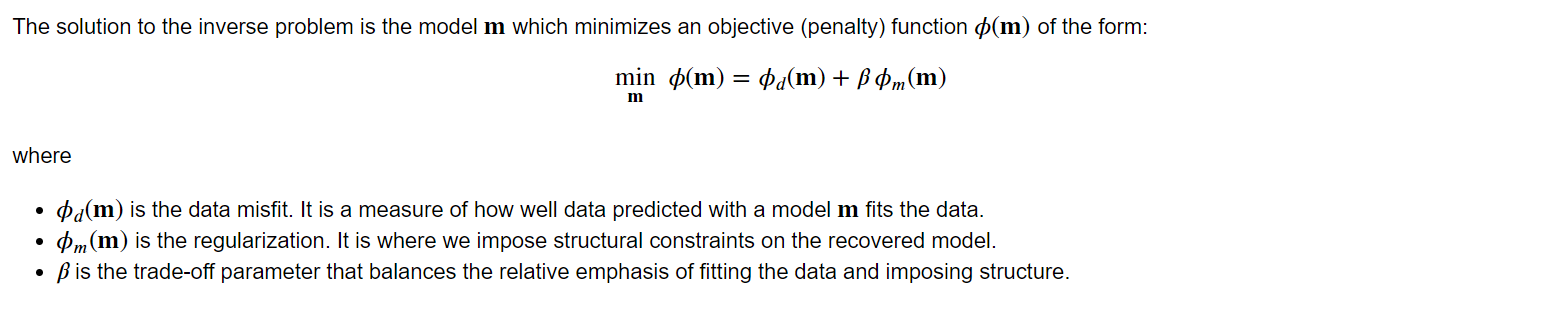

### Step 9a: Define the Data Misfit

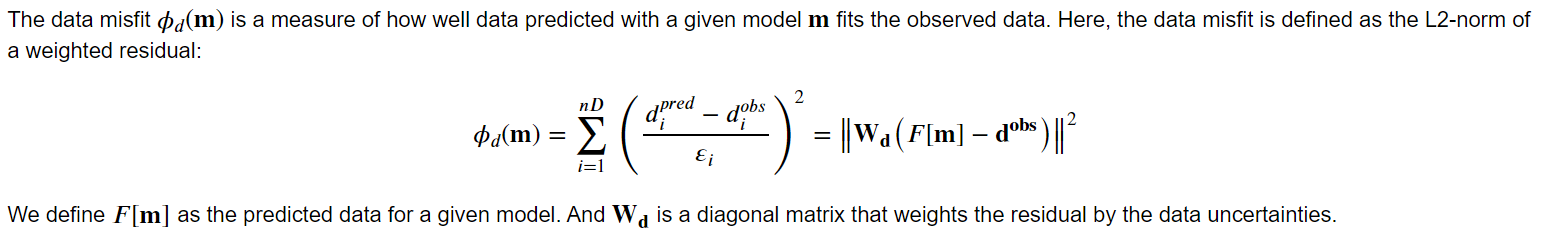

### <span style="color:darkgreen">Exercise (beginner):</span>

Generate a [data_misfit.L2DataMisfit](https://docs.simpeg.xyz/content/api/generated/SimPEG.data_misfit.L2DataMisfit.html) object and call it **dmis**. To instantiate this objected, we must set the following keyword arguments:

* **simulation=dc_simulation** (our simulation object)
* **data=dc_data** (our data object)

### Step 9b: Regularization

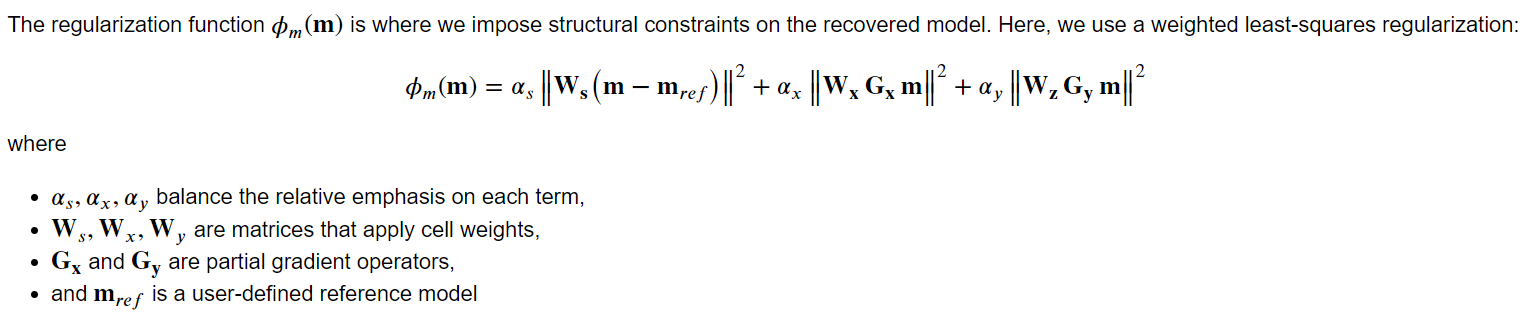

### <span style="color:darkgreen">Exercise (beginner):</span>

Generate a [regularization.WeightedLeastSquares](myst:SimPEG#SimPEG.regularization.WeightedLeastSquares) object and call it **reg**. Set to invert for the smoothest model by instantiating the object with:

* **mesh** (the mesh as an input argument)
* **active_cells=active_cells** (regularization only acts on active cells)
* **reference_model=starting_model** (set starting model as the reference model)
* **alpha_s=1e-5** (set impact of the smallness term to be negligible)

### <span style="color:darkorange">Exercise (advanced):</span>

Set the regularization to enforce smoothness roughly 10x more than smallness. Do this by setting **length_scale_x** and **length_scale_y** to **10** as keyword arguments instead of setting **alpha_s**. 

### Step 9c: Optimization

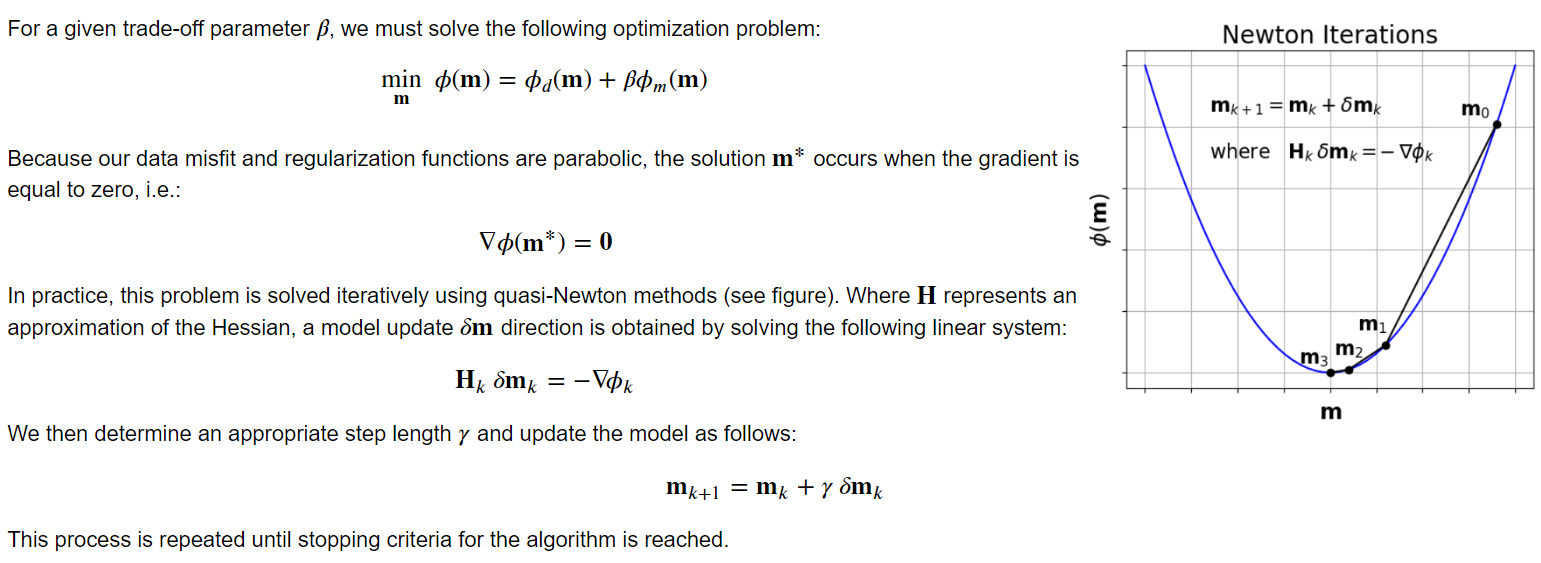


### <span style="color:darkgreen">Exercise (beginner):</span>

Generate an [optimization.InexactGaussNewton](https://docs.simpeg.xyz/content/api/generated/SimPEG.optimization.InexactGaussNewton.html) object to solve the invert problem and call it **opt**. Set the following properties for the algorithm via keyword arguments:

* **maxIter=20** (maximum number of iterations; beta and Newton)
* **maxIterLS=40** (maximum number of line searches for $\gamma$)
* **maxIterCG=20** (maximum number of conjugate gradient iterations)
* **tolCG=1e-3** (minimum relative error threshold)

### Step 9d: Inverse Problem

### <span style="color:darkgreen">Exercise (beginner):</span>

Use the [BaseInvProblem](https://docs.simpeg.xyz/content/api/generated/SimPEG.inverse_problem.BaseInvProblem.html) class to fully define the inverse problem that is solved at each beta (trade-off parameter) iteration. Use the variable name **inv_prob**. Instantiation requires the following as input arguments:

* **dmis** (the data misfit object)
* **reg** (the regularization object)
* **opt** (the optimization object)

## Step 10: Defining Inversion Directives

Directives provide specific instructions to the inversion while it is running. Here, we define SimPEG directives commonly used for least-squares DC resistivitiy inversion.

### 10a: Beta Cooling Directives

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/tikhonov_curve.png" width="40%" align="right"/>


### <span style="color:darkgreen">Exercise (beginner):</span>

Define the starting beta, schedule and target misfit directives.

* Generate a [directives.BetaEstimate_ByEig](myst:SimPEG#SimPEG.directives.BetaEstimate_ByEig) object and call it **starting_beta**. Set keyword argument **beta0_ratio=100**
* Generate a [directives.BetaSchedule](myst:SimPEG#SimPEG.directives.BetaSchedule) and call it **beta_schedule**. Set the following keyword arguments:

    * **coolingFactor=2** (reduction factor for beta)
    * **coolingRate=2** (number of Newton iterations at each beta)

* Generate a [directives.TargetMisfit](myst:SimPEG#SimPEG.directives.TargetMisfit) to set stopping criteria for the inversion and call it **target_misfit**. Set keyword argument **chifact=1** to so the inversion terminates when data misfit equals number of data.

### Other Directives

Other common directives for weighted least-squares inversion of DC resistivity data are:

- [UpdateSensitivityWeights](myst:SimPEG#SimPEG.directives.UpdateSensitivityWeights): apply sensitivity weighting to counteract the natural tendancy of DC resistivity inversion to place materials near the electrodes.

- [UpdatePreconditioner](myst:SimPEG#SimPEG.directives.UpdatePreconditioner): Apply Jacobi preconditioner when solving the optimization problem to reduce the number of conjugate gradient iterations.

- **SaveInversionProgress:** a directive we defined earlier in the notebook to allow us to better Q.C. the inversion result.

In [ ]:
sensitivity_weights = directives.UpdateSensitivityWeights(
    every_iteration=True, threshold_value=1e-2
)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
save_inversion = SaveInversionProgress()

The directive objects are organized in a ``list``. The order of the list matters so the directives have been organized for you.

In [ ]:
directives_list = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    save_inversion,
    target_misfit,
]

## Step 10: Define and Run the Inversion

### <span style="color:darkgreen">Exercise (beginner):</span>

1. Define the inversion by instantiating an [inversion.BaseInversion](https://docs.simpeg.xyz/content/api/generated/SimPEG.inversion.BaseInversion.html) object. Call this object **inv**. This object requires the **inv_prob** and **directives_list** as input arguments.
2. Use the **run** method to run the inversion. This method requires the **starting_model** as in input argument.

## Step 11: Inversion Outputs

### 11a: Extract Some Inversion Outputs

In [ ]:
iteration = save_inversion.inversion_results["iteration"]
beta = save_inversion.inversion_results["beta"]
phi_d = save_inversion.inversion_results["phi_d"]
phi_m = save_inversion.inversion_results["phi_m"]
dpred = save_inversion.inversion_results["dpred"]
models = save_inversion.inversion_results["model"]

### 11b: Plot Tikhonov Curve

In [ ]:
fig = plt.figure(figsize=(15, 6))
ax1a = fig.add_axes([0.05, 0.05, 0.35, 0.9])
ax1b = ax1a.twinx()
ax2a = fig.add_axes([0.55, 0.05, 0.35, 0.9])
ax2b = ax2a.twinx()

ax1a.plot(iteration, phi_d, "b-o")
ax1a.plot(
    iteration,
    target_misfit.chifact * dc_data.survey.nD * np.ones_like(iteration),
    "k--",
)
ax1b.plot(iteration, phi_m, "r-o")

ax1a.set_xlabel("Iteration", fontsize=20)
ax1a.set_ylabel("Data Misfit ($\phi_d$)", color="b", fontsize=18)
ax1a.tick_params(axis="y", colors="b")
ax1a.set_title("Tikhonov Curve", fontsize=20)
ax1a.set_xlim([np.min(iteration), np.max(iteration)])
ax1b.tick_params(axis="y", colors="r")
ax1b.set_ylabel("Regularization ($\phi_m$)", color="r", fontsize=18)

ax2a.semilogy(iteration, phi_d, "b-o")
ax2a.semilogy(
    iteration,
    target_misfit.chifact * dc_data.survey.nD * np.ones_like(iteration),
    "k--",
)
ax2b.semilogy(iteration, phi_m, "r-o")
ax2a.set_xlabel("Iteration", fontsize=20)
ax2a.set_ylabel("Data Misfit ($\phi_d$)", color="b", fontsize=18)
ax2a.tick_params(axis="y", which="both", colors="b")
ax2a.set_title("Tikhonov Curve", fontsize=20)
ax2a.set_xlim([np.min(iteration), np.max(iteration)])
ax2b.tick_params(axis="y", which="both", colors="r")
ax2b.set_ylabel("Regularization ($\phi_m$)", color="r", fontsize=18)

plt.show()

### 11c: Choose an Iteration to Further Examine

In [ ]:
model_iteration = -1

### 11d: Plot Observed Data, Prediced Data and Normalized Misfit

In [ ]:
dobs = dc_data.dobs
std = dc_data.standard_deviation

fig = plt.figure(figsize=(7, 9))
data_array = [
    np.abs(dobs),
    np.abs(dpred[model_iteration]),
    (dobs - dpred[model_iteration]) / std,
]
plot_title = ["Observed Data", "Predicted Data", "Normalized Misfit"]
plot_units = ["V/A", "V/A", ""]
scale = ["log", "log", "linear"]
cmap_list = [mpl.cm.viridis, mpl.cm.viridis, mpl.cm.RdYlBu]

ax1 = 3 * [None]
cax1 = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.15, 0.72 - 0.33 * ii, 0.65, 0.21])
    cax1[ii] = fig.add_axes([0.81, 0.72 - 0.33 * ii, 0.03, 0.21])
    cplot[ii] = plot_pseudosection(
        dc_data.survey,
        data_array[ii],
        "contourf",
        data_locations=True,
        ax=ax1[ii],
        cax=cax1[ii],
        scale=scale[ii],
        cbar_label=plot_units[ii],
        mask_topography=True,
        contourf_opts={"levels": 25, "cmap": cmap_list[ii]},
    )
    ax1[ii].set_title(plot_title[ii])

plt.show()

### 11e: Plot Observed and Predicted Apparent Resistivities

In [ ]:
# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    dc_data.survey,
    dobs=apparent_resistivities,
    plot_type="contourf",
    data_locations=True,
    ax=ax1,
    scale="log",
    cbar_label="$\Omega m$",
    mask_topography=True,
    contourf_opts={"levels": 40, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Apparent Resistivity (Observed)")
plt.show()

# Plot apparent conductivity pseudo-section
apparent_resistivities_dpred = apparent_resistivity_from_voltage(
    dc_data.survey, dpred[model_iteration]
)

fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    dc_data.survey,
    dobs=apparent_resistivities_dpred,
    plot_type="contourf",
    data_locations=True,
    ax=ax1,
    scale="log",
    cbar_label="$\Omega m$",
    mask_topography=True,
    contourf_opts={"levels": 40, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Apparent Resistivity (Predicted)")
plt.show()

### 11f: Plot Recovered Model

In [ ]:
air_resistivity = 1e8
background_resistivity = 1e2
block_resistivity = 1e3
basement_resistivity = 1e1

In [ ]:
# Define resistivity model
true_resistivity = background_resistivity * np.ones(mesh.n_cells)

ind_basement = mesh.cell_centers[:, -1] < -16.0
true_resistivity[ind_basement] = basement_resistivity

ind_block = model_builder.get_indices_block(
    np.r_[5.0, -10.0], np.r_[15.0, 0.0], mesh.cell_centers
)
true_resistivity[ind_block] = block_resistivity

true_resistivity = true_resistivity[active_cells]

In [ ]:
# Spatial plotting limits
x_lim = [-60, 60]
y_lim = [y_topo_max - 50, y_topo_max]

# Define a mapping to plot models and ignore inactive cells
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)
plotting_model = [true_resistivity, np.exp(models[model_iteration])]
norm = LogNorm(vmin=1e1, vmax=1e3)

fig = plt.figure(figsize=(10, 8))
ax1 = 2 * [None]
ax2 = 2 * [None]
title_str = [
    "True Resistivity",
    "Recovered Resistivity",
]

for ii in range(0, 2):
    ax1[ii] = fig.add_axes([0.14, 0.55 - 0.5 * ii, 0.68, 0.35])
    mesh.plot_image(
        plotting_map * plotting_model[ii],
        ax=ax1[ii],
        grid=False,
        pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
    )

    ax1[ii].set_xlim(x_lim)
    ax1[ii].set_ylim(y_lim)
    ax1[ii].set_title(title_str[ii])
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("y (m)")

    ax2[ii] = fig.add_axes([0.84, 0.55 - 0.5 * ii, 0.03, 0.35])
    cbar = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
    )
    cbar.set_label(r"$\rho (\Omega m)$", rotation=270, labelpad=15, size=12)

pseudo_locations_xy = pseudo_locations(dc_data.survey)
ax1[1].scatter(pseudo_locations_xy[:, 0], pseudo_locations_xy[:, -1], 1.5, "k")

plt.show()